## Raster analysis

In [1]:
import rasterio
import numpy as np
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import geopandas as gpd
import fiona
import rasterio.mask

### Exercise 1

Could not figure out how to merge the countries.tif ISO information with the population rasters to single out China...
Alternative solution employed by using country shapefile for the spatial autocorrelation exercise. This is most likely more complicated than it needs to be... 

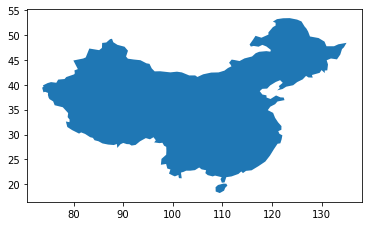

In [2]:
#open world shp file - select only China and create new shapefile = china
world = gpd.read_file("countries/ne_110m_admin_0_countries.shp")
world[world['SOVEREIGNT']=='China'].to_file('china.shp')
#plot china shapefile to see if it worked
china = gpd.read_file("china.shp")
china.plot()

Now that a China shapefile is generated - it is used to mask the population rasters in order to single out data from China. This is done by looping all population rasters 2010-2100 while also using numpy to calculate the sum of populations for each file in the loop.

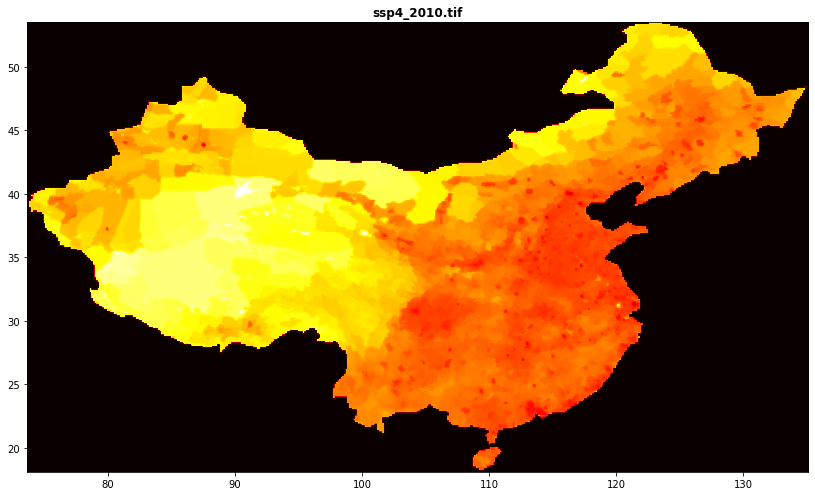

1337037105


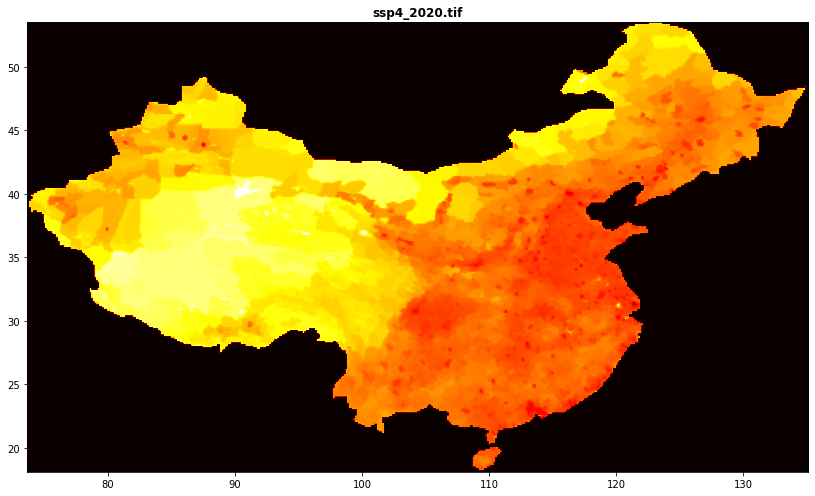

1364803846


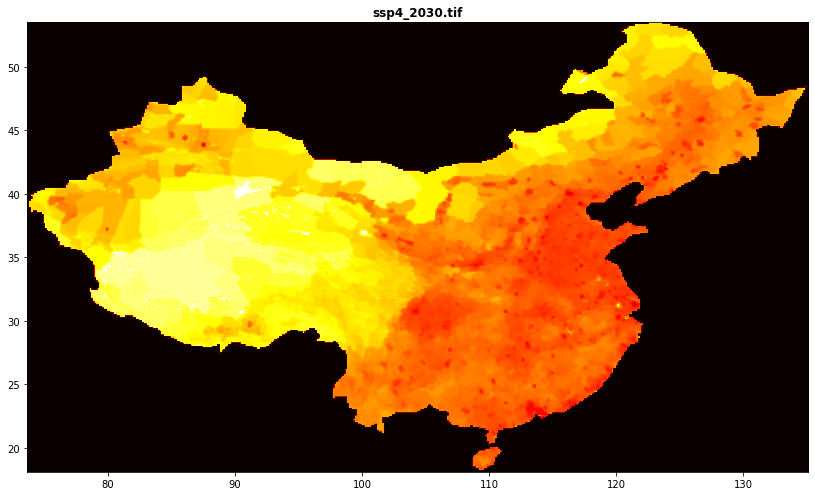

1346564551


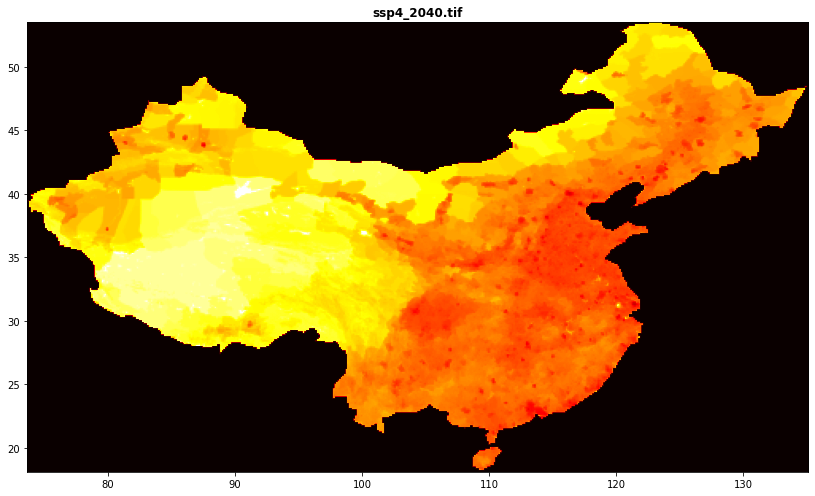

1283306741


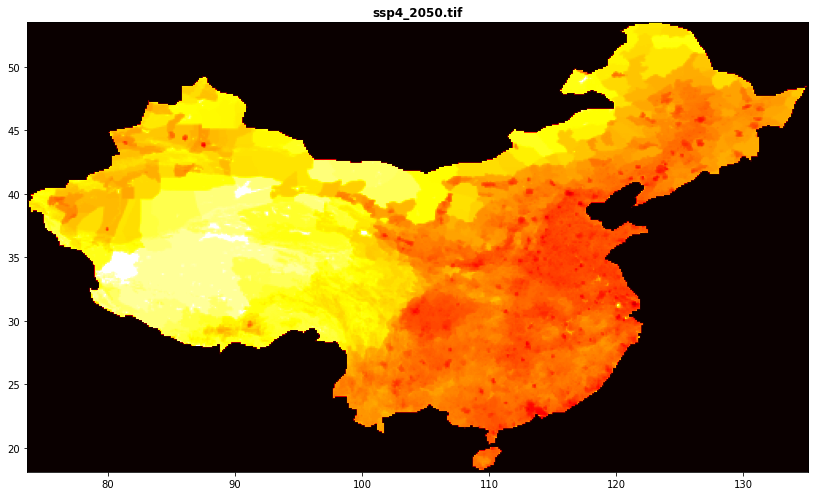

1181841088


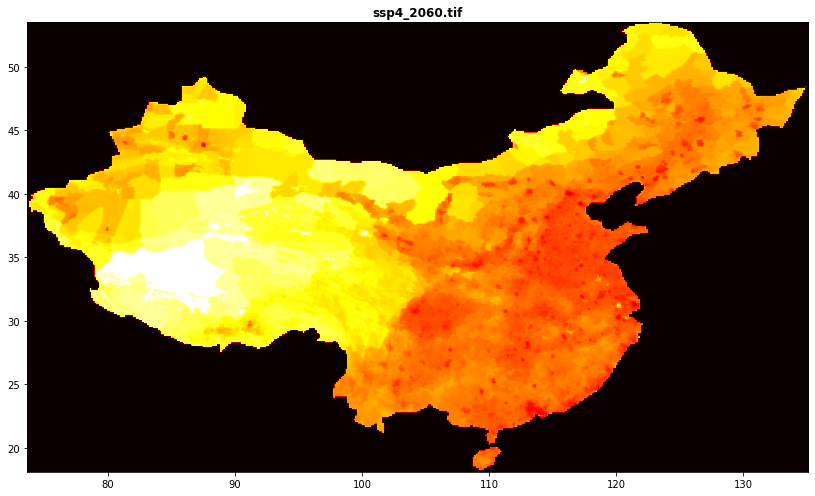

1055276741


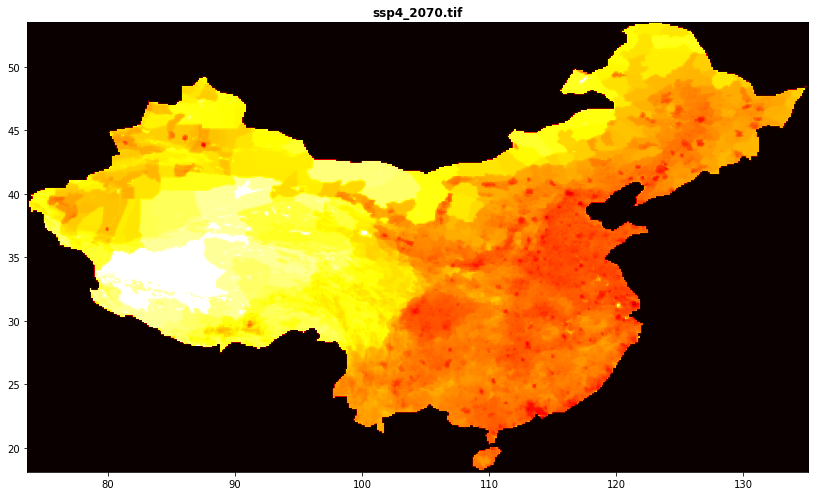

920657527


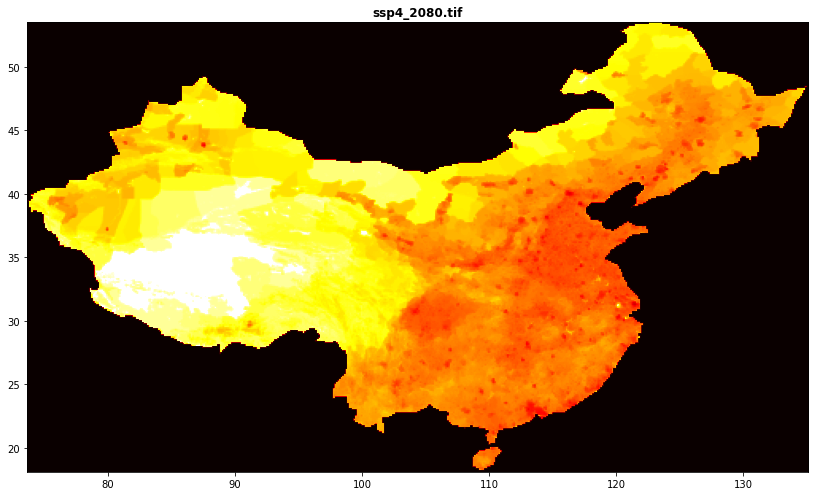

788106208


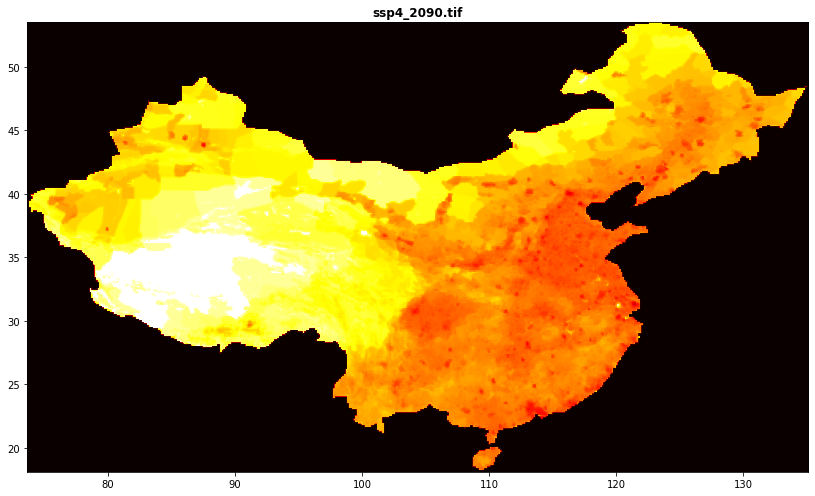

663651859


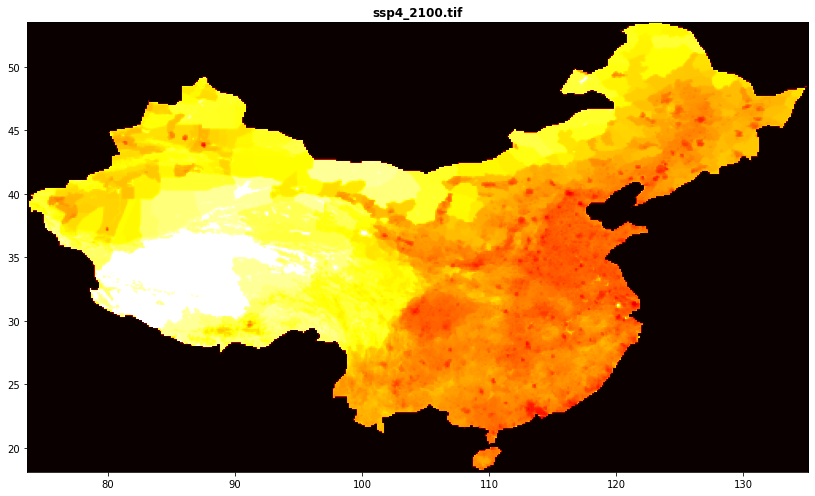

556814372


In [3]:
# loop for generating chronological maps of China and projected total populations between 2010 and 2100 
rasters = ["ssp4_2010.tif", "ssp4_2020.tif", "ssp4_2030.tif", "ssp4_2040.tif", "ssp4_2050.tif", "ssp4_2060.tif", "ssp4_2070.tif", "ssp4_2080.tif", "ssp4_2090.tif", "ssp4_2100.tif"]
for raster in rasters:
    with fiona.open("china.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open(raster, "w", **out_meta) as dest:
        dest.write(out_image)
    test = rasterio.open(raster)
    plt.figure(figsize=(14, 14))
    show((test, 1), title=raster, cmap='hot_r', norm=LogNorm())
    raster = test.read(1)
    raster[raster == 2147483647] = 0
    print(np.sum(raster)) 

#the output becomes arranged as: raster map of population 2XXX underlain by total population in 2XXX, followed by next looped file

The same procedure is repeated for the urban population data

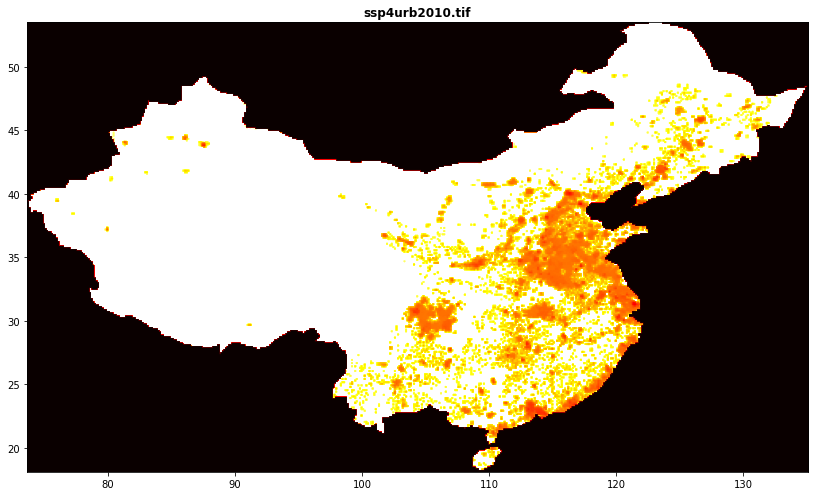

630103681


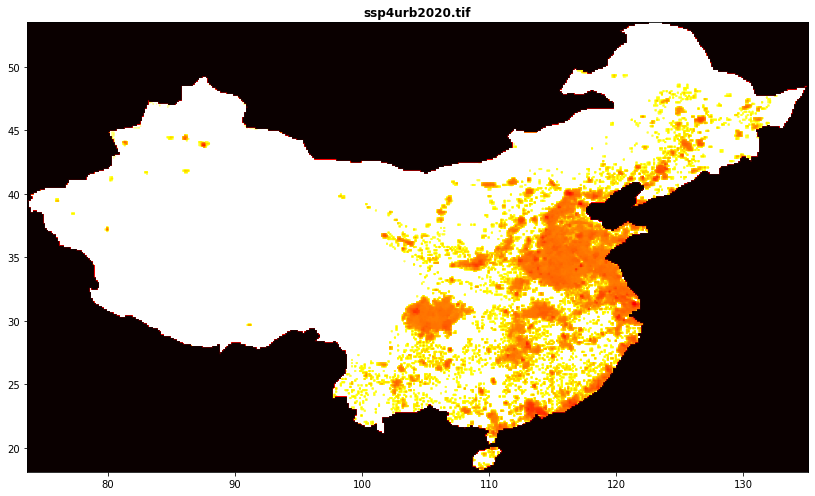

801679762


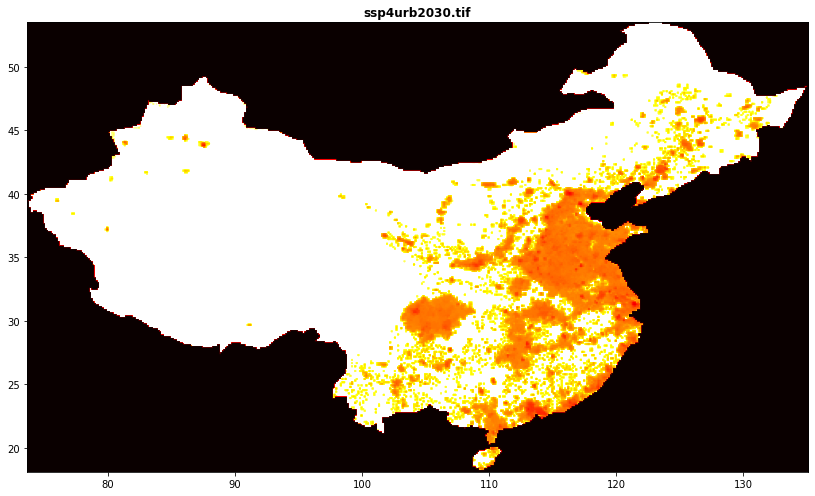

917614406


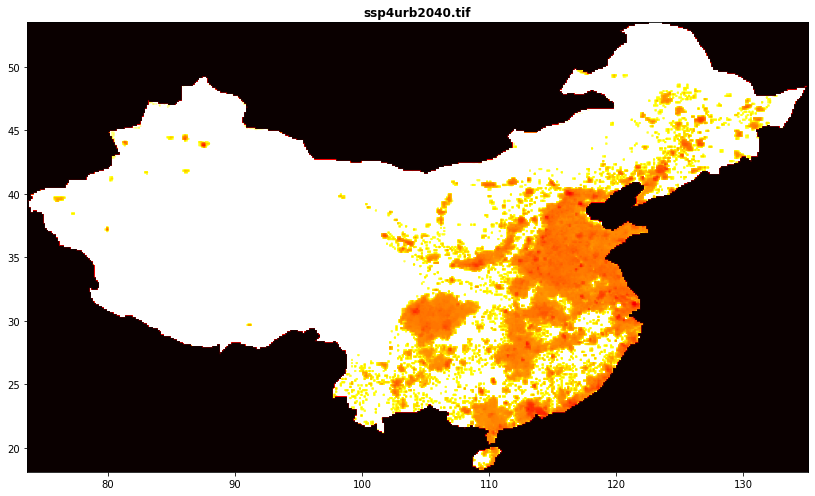

966920228


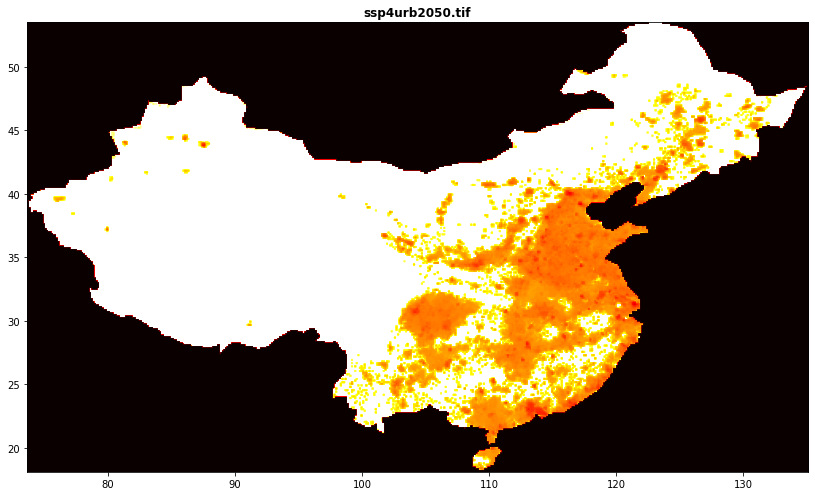

954982290


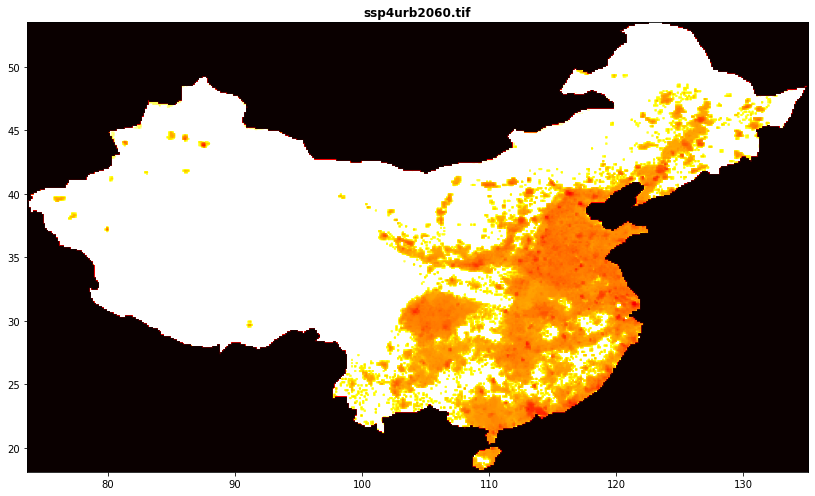

896375196


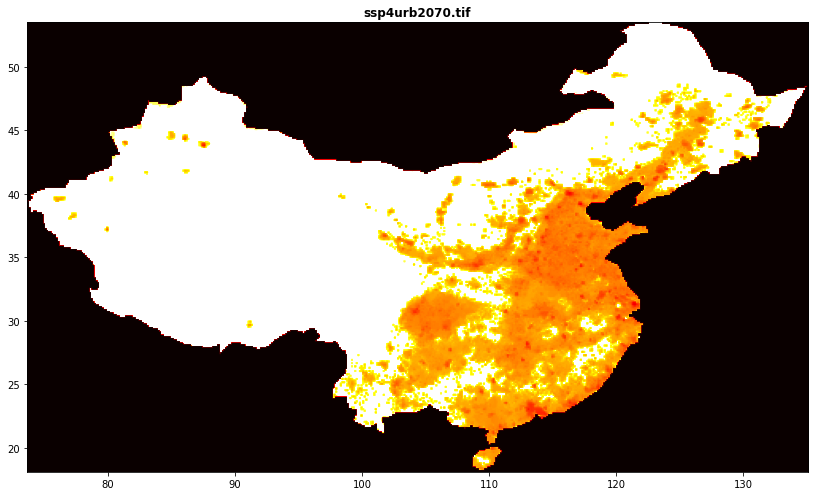

811041759


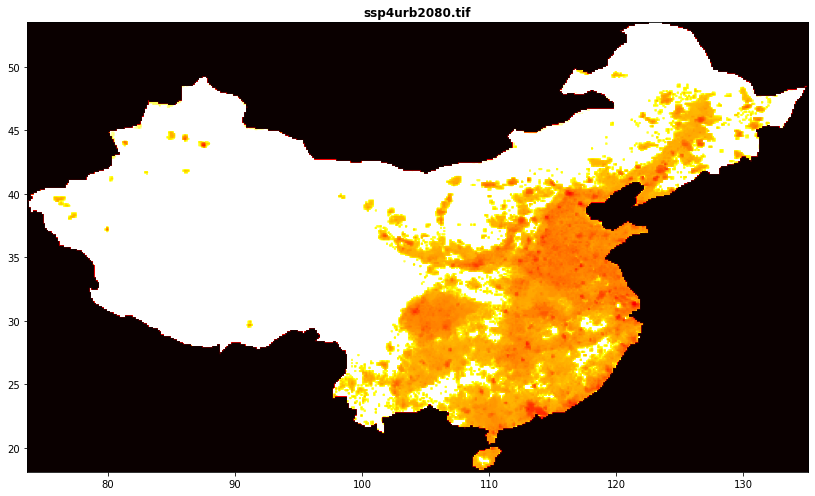

713383452


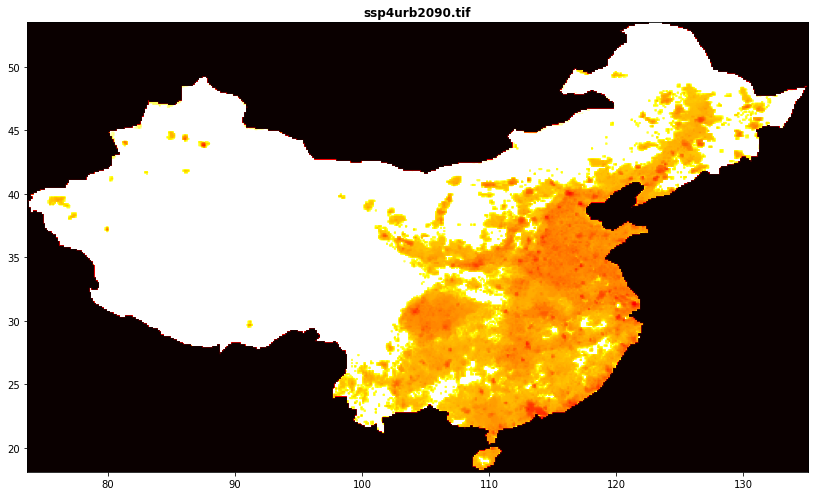

613208015


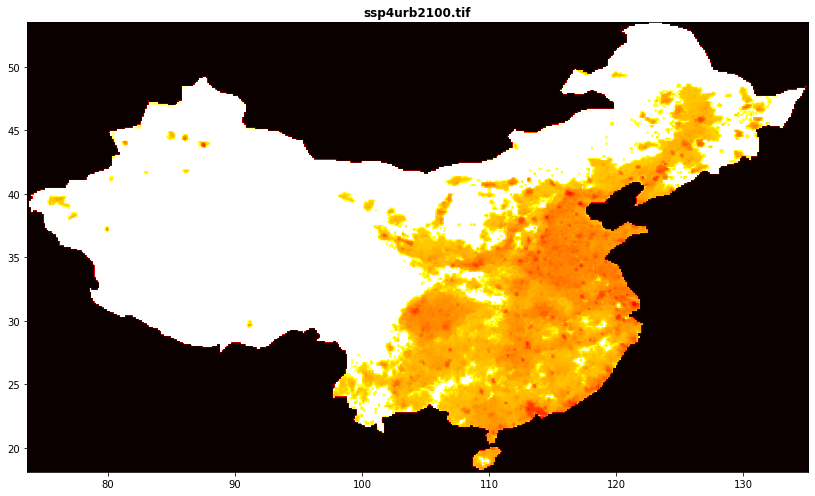

522735414


In [4]:
# loop for generating chronological maps of China and projected Urban populations between 2010 and 2100 
rasters = ["ssp4urb2010.tif", "ssp4urb2020.tif", "ssp4urb2030.tif", "ssp4urb2040.tif", "ssp4urb2050.tif", "ssp4urb2060.tif", "ssp4urb2070.tif", "ssp4urb2080.tif", "ssp4urb2090.tif", "ssp4urb2100.tif"]
for raster in rasters:
    with fiona.open("china.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open(raster, "w", **out_meta) as dest:
        dest.write(out_image)
    test = rasterio.open(raster)
    plt.figure(figsize=(14, 14))
    show((test, 1), title=raster, cmap='hot_r', norm=LogNorm())
    raster = test.read(1)
    raster[raster == 2147483647] = 0
    print(np.sum(raster))

The generated population data is plotted using plt. 
Had to read the output and write them out manually in x, y space

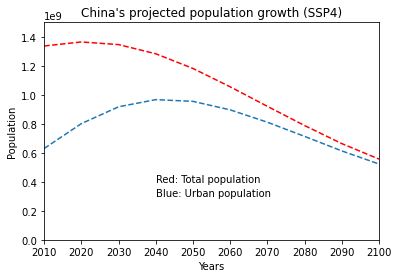

In [5]:
# disclaimer: had to read the outputs and plot the results manually - not sure how to generate a single result table from the loops
plt.plot([2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], [1337037105, 1364803846, 1346564551, 1283306741, 1181841088, 1055276741, 920657527, 788106208, 663651859, 556814372], 'r--', [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], [630103681, 801679762, 917614406, 966920228, 954982290, 896375196, 811041759, 713383452, 613208015, 522735414], '--')
plt.ylabel("Population")
plt.xlabel("Years")
plt.axis([2010, 2100, 0, 1500000000])
plt.title("China's projected population growth (SSP4)")
plt.text(2040, 400000000, "Red: Total population")
plt.text(2040, 300000000, "Blue: Urban population")
plt.show()


### Exercise 2

Here I open the total population files for 2010 and 2100. By subtracting the population count of 2010 by the projected population count of 2100 in each cell we get an array with the difference. NoData values are replaced with 0. Because many areas are projected to have an increase in population, the resulting cells will have negative values. Therefore, I "obscure" these cells by replacing negative values with 0. Thereby, I can also normalise to logarithmic values for later plots.

Disclaimer: In exercise 1 I cropped the SSP4 tiff files to only include China. Therefore, I have a new set of tif files (_2) which are uncropped.

In [6]:
#Loading files and cleaning up the data
pop2010tif = rasterio.open("ssp4_2010_2.tif")
pop2100tif = rasterio.open("ssp4_2100_2.tif")
pop2010 = pop2010tif.read(1)
pop2010[pop2010 == 2147483647] = 0
pop2100 = pop2100tif.read(1)
pop2100[pop2100 == 2147483647] = 0
pop_change = pop2010 - pop2100
pop_change[pop_change < 0] = 0


Here is the resulting map showing world population decrease between 2010 and 2100

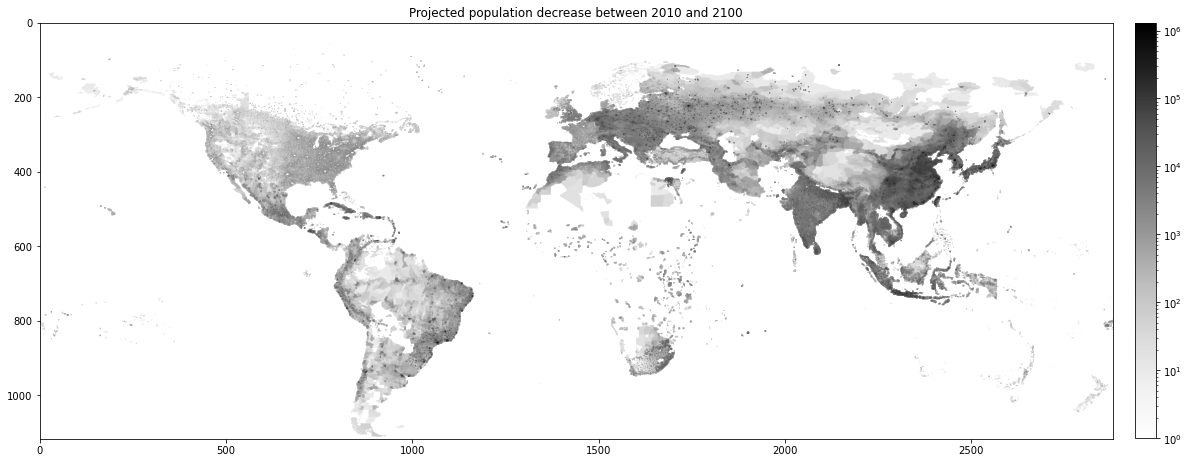

In [7]:
plt.figure(figsize=(20, 20))
imgplot = plt.imshow(pop_change, norm=LogNorm(), cmap='Greys')
plt.title('Projected population decrease between 2010 and 2100')
plt.colorbar(fraction=0.0186, pad=0.02)

This plot may look a bit misleading as one may conclude that most of the world will have experienced population decrease due to the lognorm and small cellsize. In fact many countries likely experience relocation from rural areas to urban areas. Such plots could be coupled with the same plot showing pop increase as follows.

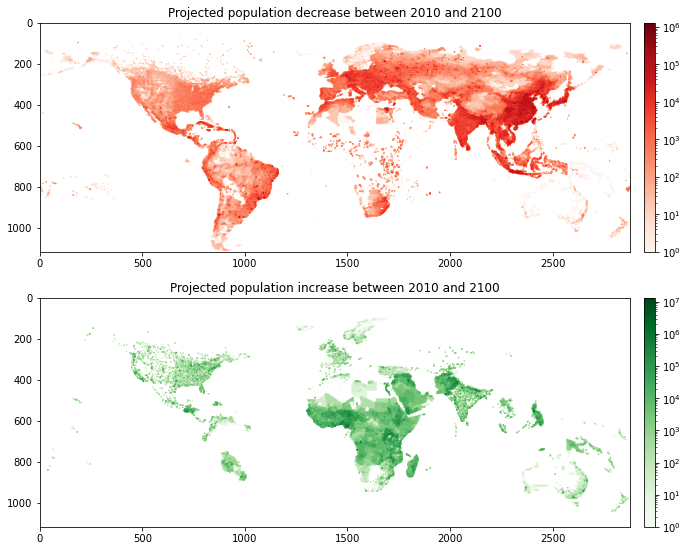

In [8]:
#calculate projected population increase "pop_change2"
pop_change2 = pop2100 - pop2010
pop_change2[pop_change2 < 0] = 0

#plot both projected population increase and decrease
plt.figure(figsize=(14, 14))
plt.subplot(211)
imgplot = plt.imshow(pop_change, norm=LogNorm(), cmap='Reds')
plt.title('Projected population decrease between 2010 and 2100')
plt.colorbar(fraction=0.0186, pad=0.02)
plt.subplot(212)
imgplot = plt.imshow(pop_change2, norm=LogNorm(), cmap='Greens')
plt.title('Projected population increase between 2010 and 2100')
plt.colorbar(fraction=0.0186, pad=0.02)
plt.subplots_adjust(bottom=0.4, right=0.8, top=0.9)
plt.show()